# Website Phishing (scikit-learn)
---
#### Denis Alexander Zuluaga Quintero
dazuluag@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

#### Contenido
* [Comprensión del problema real](#Comprensión-del-problema-real)
* [Comprensión de los datos](#Comprensión-de-los-datos)
* [Preparación de los datos](#Preparación-de-los-datos)
* [Modelado y Evaluación](#Modelado-y-Evaluación)
* [Análisis de resultados](#Análisis-de-resultados)

# Comprensión del problema real
---

### Objetivos del negocio
El problema de suplantación de identidad (phishing) se considera un problema vital en la industria .COM, especialmente en la banca electrónica y el comercio electrónico. Cuando un sitio web se considera **Sospechoso**, significa que puede ser **Phishy** o **Legítimo**, lo que implica que el sitio web tiene características legítimas y de phishing. El problema requiere realizar la clasificación de cuando un sitio web es legítimo, phishing o sospechoso.

### Objetivos de la míneria de datos
El autor del conjunto de datos a identificado diferentes características relacionadas con sitios web legítimos y phishy. Se recopiló 1353 sitios web diferentes de diferentes fuentes. Los sitios web de prostitución fueron obtenidos del conjunto de datos [Phishtank](www.phishtank.com), sitio gratuito donde los usuarios pueden enviar, verificar, rastrear y compartir datos de phishing. Los sitios web legítimos se recopilaron de Yahoo y los directorios mediante un script web desarrollado en PHP. El script PHP fue conectado con un navegador y se recolectaron 548 sitios web legítimos de 1353 sitios web. Hay 702 URL de phishing y 103 URL sospechosas. Se pretende por tanto modelar y evaluar con que precisión es posible clasificar sitios web como phishing. 

### Referencias
Abdelhamid et al.,(2014a) Phishing Detection based Associative Classification Data Mining. Expert Systems With Applications (ESWA), 41 (2014) 5948-5959.
- Fuente: [UCI](https://archive.ics.uci.edu/ml/datasets/Website+Phishing)

# Comprensión de los datos
---

Las características o atributos recopilados tienen los valores categóricos: Legitimate, Suspicious y Phishy. Estos valores han sido reemplazados con los valores numéricos 1, 0 y -1 respectivamente. Los detalles de cada característica se mencionan en el documento de investigación del autor.

**Características del conjunto de datos**
- SFH: manejador de formulario en servidor (si esta vacío o "about:blank" es phishing)
- popUpWindow: ventana emergente (si contiene campos de texto es phishing)
- SSLfinal_State: estado final SSL (no tiene certificados de confianza es phishing)
- Request_URL: URL de la solicitud (> 66% de contenido de otro dominio es phishing)
- URL_of_Anchor: enlace anclado en el sitio (> 67% cantidad de etiquetas "a" fuera del dominio o ningún link es phishing)
- web_traffic: popularidad del sitio web (no tiene tráfico o no es reconocido por Alexa es phishing)
- URL_Length: longitud de la URL del sitio (> 54 catacteres es phishing)
- age_of_domain: tiempo de vida del sitio (> a 6 meses es phishing)
- having_IP_Address: ¿el sitio utiliza dirección IP? (es phishing cuando utiliza)

**Variable objetivo del conjunto de datos**
- Result: indicador de sitio legítimo (1), sospechoso (0) y phishing (-1)

**Nota:** Cada una de las características puede tener el valor 0, 1 y -1 según como se haya interpretado en el sitio web analizado. El valor 0 indica que la característica es sospechosa, un valor de 1 representa que el atributo es legítimo y -1 indica que es malicioso o phishing.

### Carga de los datos

In [1]:
##
## Eliminamos salida de warnings
##
import warnings as ws
ws.filterwarnings("ignore")

##
## Importamos las librerias requeridas
##
import time as tm
import itertools
from itertools import chain
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

##
## Función para colorear fondo en un Data Frame
## http://pandas.pydata.org/pandas-docs/stable/style.html
##
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: cyan' if v else '' for v in is_max]

In [2]:
##
## Realizamos la lectura del archivo con el conjunto de datos
##
data = pd.read_csv('PhishingData.csv', sep=",")

##
## Creamos una variable con la cantidad de registros total
##
N,M = data.shape

##
## Imprimimos una muestra de los datos
##
data.head()

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [3]:
##
## Agrego una nueva variable tipo texto representando la variable objetivo
##
if not 'Class' in data.columns:
    data["Class"] = ""
    data["Class"][data["Result"] == 1] = "Legitimate"
    data["Class"][data["Result"] == 0] = "Suspicious"
    data["Class"][data["Result"] == -1] = "Phishing"

##
## Imprimimos una muestra de los datos
##
data.head()

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result,Class
0,1,-1,1,-1,-1,1,1,1,0,0,Suspicious
1,-1,-1,-1,-1,-1,0,1,1,1,1,Legitimate
2,1,-1,0,0,-1,0,-1,1,0,1,Legitimate
3,1,0,1,-1,-1,0,1,1,0,0,Suspicious
4,-1,-1,1,-1,0,0,-1,1,0,1,Legitimate


### Exploración de los datos

#### Validación balance de la variable objetivo

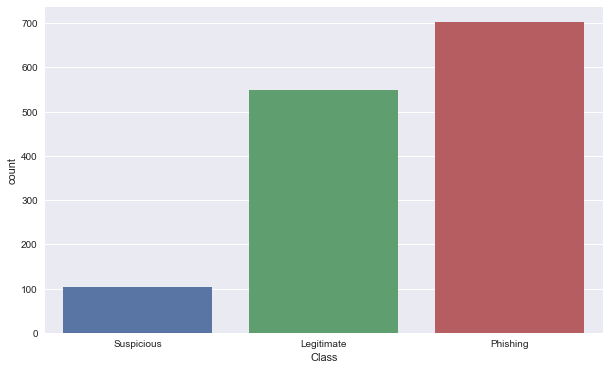

In [4]:
##
## Confirmamos la densidad de registros
##
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="Class", data=data, ax=ax)

In [5]:
##
## Mostramos balance de registros en porcentaje por categoria
##
category = pd.Categorical.from_array(data.Class)
freqs = category.describe().freqs
class_name = list(freqs.index.categories)
class_name = [class_name[2], class_name[0], class_name[1]]
class_freq = list([str(int(round(i, 2)*100))+"%" for i in freqs.values])
class_freq = [[class_freq[2], class_freq[0], class_freq[1]]]
pd.DataFrame(data=class_freq, columns=class_name)

,Suspicious,Legitimate,Phishing
0,8%,41%,52%


El resultado anterior indica que el **41%** de los datos corresponde a sitios legítimos y el **52%** a sitios categorizados como phishing, dejanto tanto solo un **8%** de sitios que son sospechosos. Podemos considerar que la muestra de registros se encuentra balanceada.

#### Estadísticos del conjunto de datos

In [6]:
##
## Verificamos la lectura de los datos con estadísticos básicos
##
data.describe()

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,0.237990,-0.258684,0.327421,-0.223208,-0.025129,0.000000,-0.053215,0.219512,0.114560,-0.113821
std,0.916389,0.679072,0.822193,0.799682,0.936262,0.806776,0.762552,0.975970,0.318608,0.954773
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000
25%,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


La tabla anterior permite deducir que todas las variables del conjunto de datos se encuentran **a una misma escala**, por lo tanto, no se requiere realizar procesos de normalización o estandarización. También deducimos que los datos no siguen ninguna distribución dado el rango de valores que toman: {-1, 0, 1}

#### Análisis de correlaciones entre atributos

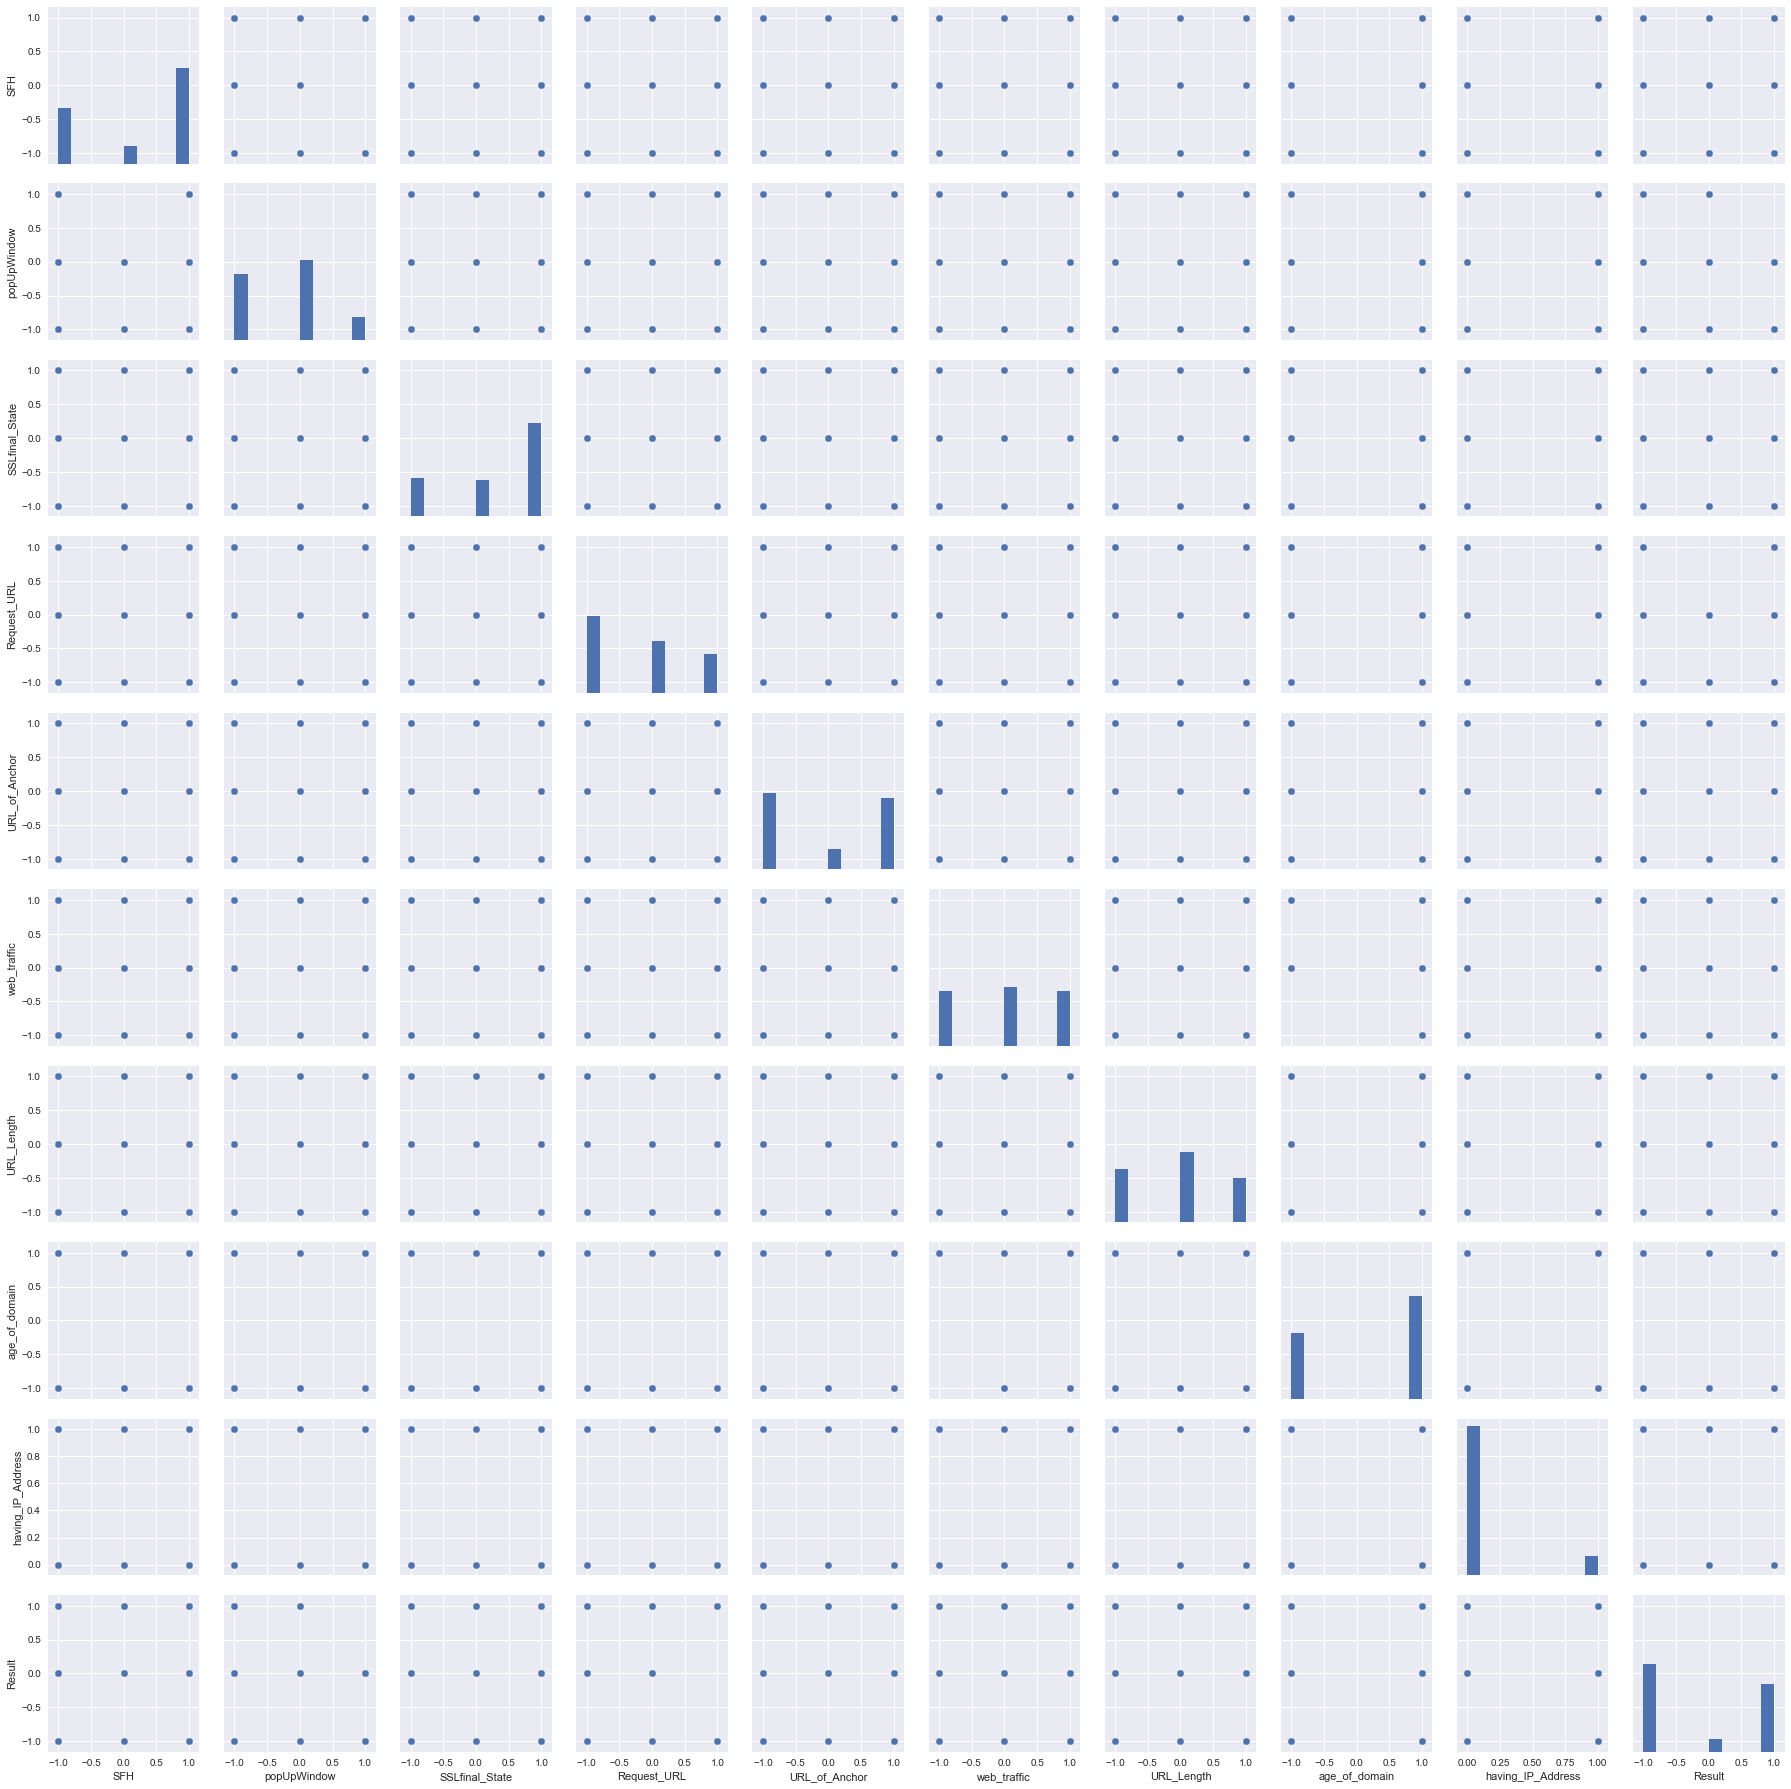

In [7]:
##
## Graficamos histogramas por variable y dispersión para cada combinación par
##
sns.pairplot(data)

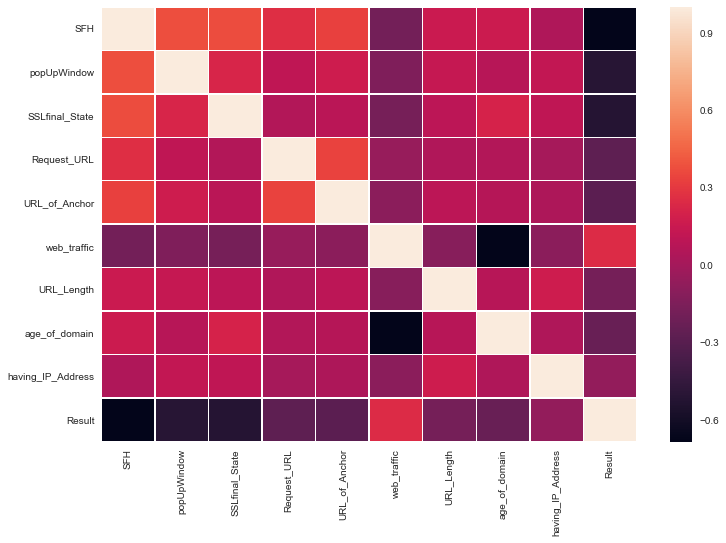

In [8]:
##
## Correlaciones para las variables del conjunto de datos
##
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(method = 'pearson'), fmt="d", linewidths=.5, ax=ax)

Las gráficas anteriores permiten concluir que los atributos **no siguen una distribución normal**. Igualmente, entendemos que **no pueden correlacionarse**, es decir, ningún par de características sigue una tendencia proporcional o inversa que este cercana a 1 o -1. Por lo tanto, no se procederá con análisis de componentes principales (PCA) ni con selección de características (Feature Selection).

### Verificación de calidad de datos
Realizamos un chequeo de los tipos de dato que tiene cada variable de la muestra, debemos asegurarnos que tanto las características como la variable objetivo tengan tipos numéricos para asegurar un adecuado procesamiento de las metodologías de modelado.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 11 columns):
SFH                  1353 non-null int64
popUpWindow          1353 non-null int64
SSLfinal_State       1353 non-null int64
Request_URL          1353 non-null int64
URL_of_Anchor        1353 non-null int64
web_traffic          1353 non-null int64
URL_Length           1353 non-null int64
age_of_domain        1353 non-null int64
having_IP_Address    1353 non-null int64
Result               1353 non-null int64
Class                1353 non-null object
dtypes: int64(10), object(1)
memory usage: 116.4+ KB


El primer indicador es que ninguno de los atributos tiene datos **Nulos**. Por otro lado, confirmamos que los tipos de datos para las características y la variable objetivo son correctos: **int64**. La variable *Class* no se tiene en cuenta en este análisis ya que será retirada en la fase de preparación de datos.

# Preparación de los datos
---

Considerando que no se requiere realizar eliminación de características por correlaciones, transformación de tipos de datos, estandarización o normalización, selección de características y análisis de componentes principales, procederemos con el retiro de la variable **Class** del conjunto de datos, dado que no se requieren más tareas exploratorias. Igualmente, separaremos la variable objeto de las características para pronostico e finalmente se generará el conjunto de entrenamiento y prueba.

### Selección de los datos

In [10]:
##
## Eliminamos las columnas no requeridas
##
if 'Class' in data.columns:
    data.drop(columns=["Class"], inplace=True)

##
## Presentamos un parte de los datos sin la columna eliminada
##
data.head()

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [11]:
##
## Separamos la varible objetivo del conjunto de datos
##
X_columns = [name for name in data.columns if name != "Result"]   # Nombres caracteristicas modelado
y = data.loc[:,"Result"]   # Datos variable objetivo
X = data.loc[:,X_columns]  # Datos caracteristicas modelado
X_names = X.columns    # Nombres caracteristicas modelado

##
## Convertimos los valores objetivos en enteros, para que no genere error el fit
##
y = y.astype('int')

##
## Realizamos una copia del conjunto de características y variable objetivo original
##
X_org = X.copy()
y_org = y.copy()

### Construcción de datos

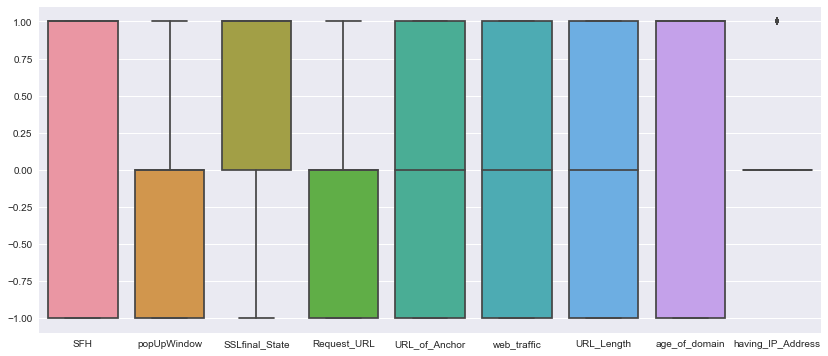

In [12]:
##
## Validamos escala de valores entre las caractetisticas de modelado
##
f, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=X, ax=ax)

Como se expresó anteriormente, **no se realizará escalado** de los datos, dado que la gráfica anterior evidencia que las unidades de los atributos esta dentro del mismo rango.

# Modelado y Evaluación
---

### Selección de la técnica de modelado

Para realizar el modelado predictivo se utilizaran las siguientes metodologías de clasificación:
- [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html)
- [Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [C-Support Vector](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Para cada una se realizará un proceso de modelado y evaluación utilizando [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) e [hyper-parameters tuning](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Al final del proceso y luego de examinar los scores (accuracy, confusion matrix) será seleccionado el modelo con mejor **desempeño**. Los parámetros generales del ajuste de hiperparametros son los siguientes:
- Cross Validation: 5-Folds
- Scoring: macro
- Number of Jobs: 3

Para comenzar, realizamos partición de los datos en **Entrenamiento** y **Prueba** utilizando una proporción del conjunto de datos 70% y 30%, respectivamente y un valor único semilla para que siempre escoja los mismos valores aleatoriamente (44).

In [13]:
##
## Definimos variables para el estándar de partición 70% - 30%
##
test_size = 0.3
random_state = 44

##
## Partición de los datos para probar todos los modelos
##
X_train, X_test, y_train_true, y_test_true = train_test_split(
    X, y,                       # datos originales
    test_size=test_size,        # float/int, tamaño de la muestra de prueba
    random_state=random_state)  # semilla del generador aleatorio

In [14]:
##
## Construimos una función personalizada para ejecutar cada metodología
##
def grid_search_custom(classifier,
                       tuned_params,
                       scores):
    scores_result = []
    for score in scores:
        print()
        print("Parámetros ajustados del score: %s" % score)
        print()

        # Entrenamiento utilizando cross-validation (folds = 5)
        clf = GridSearchCV(classifier, tuned_params, cv=5, scoring='%s_macro' % score, n_jobs=3)
        clf.fit(X_train, y_train_true)
        
        print("Mejores parámetros encontrados:")
        print(clf.best_params_)
        print()
        
        # Predicción con datos de prueba para validar metricas
        y_true, y_pred = y_test_true, clf.predict(X_test)
        
        print("Reporte de clasificación detallado:")
        print()
        print(classification_report(y_true, y_pred))
        print()
        
        # Calculo de las métricas de precisión
        accuracy_result = accuracy_score(y_true, y_pred)
        conf_matrix_result = confusion_matrix(y_true, y_pred)
        
        scores_result.append([score, 
                              round(accuracy_result, 4), 
                              round(1-accuracy_result, 4), 
                              clf.best_params_,
                              conf_matrix_result])
    
    return(scores_result)

### Metodología K-Nearest Neighbors

In [15]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'n_neighbors': [11, 31, 51, 71, 91]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
knn_result = grid_search_custom(KNeighborsClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'n_neighbors': 11}

Reporte de clasificación detallado:

             precision    recall  f1-score   support

         -1       0.87      0.89      0.88       194
          0       0.73      0.28      0.40        40
          1       0.81      0.90      0.85       172

avg / total       0.83      0.83      0.82       406




### Metodología Decision Tree

In [16]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'max_depth': [10, 20, 30, 40, 50]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
tree_result = grid_search_custom(DecisionTreeClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'max_depth': 50}

Reporte de clasificación detallado:

             precision    recall  f1-score   support

         -1       0.87      0.93      0.90       194
          0       0.90      0.65      0.75        40
          1       0.91      0.90      0.90       172

avg / total       0.89      0.89      0.89       406




### Metodología Random Forest

In [17]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'n_estimators': [20, 40, 60, 80, 100]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
forest_result = grid_search_custom(RandomForestClassifier(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'n_estimators': 40}

Reporte de clasificación detallado:

             precision    recall  f1-score   support

         -1       0.88      0.94      0.91       194
          0       0.88      0.55      0.68        40
          1       0.90      0.91      0.90       172

avg / total       0.89      0.89      0.88       406




### Metodología C-Support Vector Machine

In [18]:
print(__doc__)

# Ajuste de parámetros para la metodología
tuned_params = [{'kernel': ['rbf'], 'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100]},
                {'kernel': ['linear'], 'C': [1, 10, 100]}]

# Metricas seleccionadas para validar metodología
scores = ['precision']

# Ejecutamos grid search para la metodología
svm_result = grid_search_custom(SVC(), tuned_params, scores)

Automatically created module for IPython interactive environment

Parámetros ajustados del score: precision

Mejores parámetros encontrados:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Reporte de clasificación detallado:

             precision    recall  f1-score   support

         -1       0.91      0.93      0.92       194
          0       0.86      0.62      0.72        40
          1       0.88      0.91      0.89       172

avg / total       0.89      0.89      0.89       406




### Evaluación del modelado
A continuación se presentará un reporte de los resultados obtenidos del proceso de modelado con las 4 metodologías seleccionadas: K-Nearest Neighbors, Decision Tree, Random Forest y C-Support Vector Machine. Este reporte muestra las métricas de accuracy y error rate. Se evaluaran los resultados y se tomará una decisión respecto del modelo con **mejor desempeño**.

In [19]:
##
## Construimos un Data Frame con todos los resultados de la evaluación
##
data_indexes = ["KNearestNeighbors", "DecisionTree", "RandomForest", "SupportVectorMachine"]
data_columns = ["score", "accuracy", "error_rate", "best_params", "confusion_matriz"]
data_values = [list(chain.from_iterable(knn_result)),
               list(chain.from_iterable(tree_result)),
               list(chain.from_iterable(forest_result)),
               list(chain.from_iterable(svm_result))]
data_result = pd.DataFrame(data = data_values, columns = data_columns, index = data_indexes)

##
## Mostramos los resultados de la evaluación con todos los scores
## Con un fondo de color se muestra la mejor estimación
##
data_result.iloc[:,:-1].style.apply(highlight_max, 
                                    subset=['accuracy'])

,score,accuracy,error_rate,best_params
KNearestNeighbors,precision,0.835,0.165,{'n_neighbors': 11}
DecisionTree,precision,0.8892,0.1108,{'max_depth': 50}
RandomForest,precision,0.8892,0.1108,{'n_estimators': 40}
SupportVectorMachine,precision,0.8916,0.1084,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"


Los resultados de **desempeño** anteriores muestran con claridad que el algorítmo que mejor se comporta, dadas las medidas de Accuracy es **C-Support Vector Machine** y los mejores parámetros del clasificador con *'C': 10, 'gamma': 0.1, 'kernel': 'rbf'*; sin embargo, realizaremos un análisis más detallado de los resultados tomando como base los algorítmos con mayor desempeño: **Random Forest** y **C-Support Vector Machine**.

In [20]:
##
## Nueva matrix de confusión solo con los registros de los clasificadores seleccionados
##
conf_matrix = list(chain.from_iterable(data_result.iloc[:,4:5].values))
conf_matrix_new = [conf_matrix[2], conf_matrix[3]]
data_index_new = [data_indexes[2], data_indexes[3]]

##
## Elimino los registros de sospechosos
##
conf_matrix_copy = conf_matrix_new.copy()
conf_matrix_new = []
for i in range(len(conf_matrix_copy)):
    conf_matrix_aux1 = []
    for j in range(len(conf_matrix_copy[i])):
        if j != 1:
            conf_matrix_aux2 = []
            for k in range(len(conf_matrix_copy[i][j])):
                if k != 1:
                    conf_matrix_aux2.append(conf_matrix_copy[i][j][k])
            conf_matrix_aux1.append(conf_matrix_aux2)
    conf_matrix_new.append(np.array(conf_matrix_aux1, int))

# Análisis de resultados
---

Tomando como referencia los resultados anteriores, con las diferentes evaluaciones de desempeño de los modelos seleccionados, se procederá a realizar un análisis de los resultados de las predicciones utilizando **matrices de confusión** y los indicadores de **Sensibilidad** y **Especifidad**.

#### Matriz de confusión:

             | Pronostico
             |  P     N  
    ---------|------------
          P  |  TP    FN  
    Real     |            
          N  |  FP    TN  
    
- TP: Verdadero positivo (correcto)
- TN: Verdadero negativo (correcto)
- FP: Falso positivo (mal clasificado)
- FN: Falso negativo (mal clasificado)

#### Sensibilidad o tasa verdadera positiva:
* Mide la proporción de ejemplos positivos que fueron correctamente clasificados.

$$\text{sensitibity} = \frac{\text{TP}}{\text{TP}  + \text{FN}}$$

#### Especifidad o tasa verdadera negativa:
* Mide la proporción de ejemplos negativos correctamente clasificados.

$$\text{specifity} = \frac{\text{TN}}{\text{TN}  + \text{FP}}$$

#### Precisión o valor predictivo positivo:
* Proporción de casos positivos que fueron verdaderamente positivos.

$$\text{precision} = \frac{\text{TP}}{\text{TP}  + \text{FP}}$$

#### Valor predictivo negativo:
* Proporción de casos negativos que fueron verdaderamente negativos.

$$\text{negative predictive value} = \frac{\text{TN}}{\text{TN}  + \text{FN}}$$

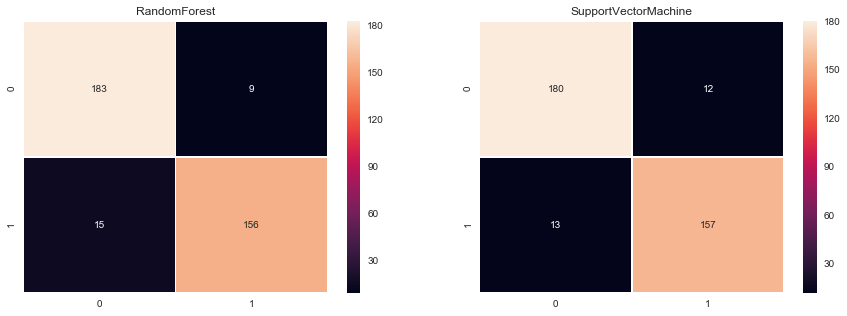

In [21]:
##
## Graficamos las matrices de confusión para los mejores estimadores
##
pred, true = ('predicted', 'true')
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(len(axes)):
    axes[i].set_title(data_index_new[i])
    axes[i].set_xlabel(pred); axes[i].set_ylabel(true)
    sns.heatmap(conf_matrix_new[i], annot=True, fmt="d", linewidths=.5, ax=axes[i])

In [22]:
##
## Calculamos los indicadores requeridos para análisis
##
data_ind_values = []
for i in range(len(conf_matrix_new)):
    tp, fn, fp, tn = conf_matrix_new[i].ravel()
    prevalence = (tp+fn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn)
    specifity = tn/(tn+fp)
    precision = tp/(tp+fp)
    neg_pred_val = tn/(tn+fn)
    data_ind_values.append([data_index_new[i], 
                            #round(prevalence,4),
                            round(sensitivity,4), 
                            round(specifity,4), 
                            round(precision,4), 
                            round(neg_pred_val,4)])

data_ind_columns = ['estimator', 'sensitivity', 'specifity', 'precision', 'negative pred value']
data_ind = pd.DataFrame(columns = data_ind_columns, data = data_ind_values)
data_ind.style.apply(highlight_max, subset = ['sensitivity', 'specifity', 'precision', 'negative pred value'])

,estimator,sensitivity,specifity,precision,negative pred value
0,RandomForest,0.9531,0.9123,0.9242,0.9455
1,SupportVectorMachine,0.9375,0.9235,0.9326,0.929
